[참고 캐글 커널](https://www.kaggle.com/davids1992/speech-representation-and-data-exploration)

In [2]:
!pip uninstall seaborn -y
!python -m pip install seaborn

  Using cached seaborn-0.11.1-py3-none-any.whl (285 kB)


In [16]:
!pip show librosa 

Name: librosa
Version: 0.8.0
Summary: Python module for audio and music processing
Home-page: https://librosa.org
Author: Brian McFee
Author-email: brian.mcfee@nyu.edu
License: ISC
Location: /Users/jaeyoungshin/opt/anaconda3/envs/python3.7/lib/python3.7/site-packages
Requires: numba, audioread, resampy, numpy, soundfile, pooch, scipy, scikit-learn, decorator, joblib
Required-by: noisereduce


In [15]:
!pip show numpy

Name: numpy
Version: 1.19.5
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: None
License: BSD
Location: /Users/jaeyoungshin/opt/anaconda3/envs/python3.7/lib/python3.7/site-packages
Requires: 
Required-by: tensorflow, tensorboard, seaborn, scipy, scikit-learn, resampy, pandas, opt-einsum, numba, noisereduce, matplotlib, librosa, Keras, Keras-Preprocessing, h5py


In [14]:
!pip install plotly

     |████████████████████████████████| 13.2 MB 2.0 MB/s eta 0:00:01
  Using cached retrying-1.3.3.tar.gz (10 kB)
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11429 sha256=31285b2ccfb7eb9db422e2b7b0c9faa865fa1cce56e51e9baaee962458b009c0
  Stored in directory: /Users/jaeyoungshin/Library/Caches/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

## Visualization
#### Two theories of human hearing
* [place theory](https://en.wikipedia.org/wiki/Place_theory_(hearing)) (frequecy-based)
* [temporal theory](https://en.wikipedia.org/wiki/Temporal_theory_(hearing))

#### In speech recognition, these are two main tendencies
* spectrogram(frequencies)
* MFCC(Mel-Frequency Cepstral Coefficients)

### Wave and spectrogram

In [2]:
train_audio_path = '../DSP study/tensorflow-speech-recognition-challenge/train/audio/'
filename = 'yes/0a7c2a8d_nohash_0.wav'
sample_rate, samples = wavfile.read(train_audio_path + filename)

spectrogram을 계산하는 함수 정의.
plot을 더 명확하게 만들기 위해 spectrogram 값에 로그를 취한다. 이는 사람이 듣는 방법과도 엄밀히 연결되어 있다. 일단 로그 취하기 전에 입력값에 0이 없도록 해야 한다.

In [3]:
def log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    # nperseg: Length of each segment
    # noverlap: Number of points to overlap between segments
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio, fs=sample_rate,
                                            window='hann', nperseg=nperseg,
                                            noverlap=noverlap, detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

[Nyquist theorem](https://en.wikipedia.org/wiki/Nyquist_rate) (나이키스트 샘플링 이론) 에 따르면 주파수의 범위는 (0, 8000) 이다.

Text(0.5, 0, 'Seconds')

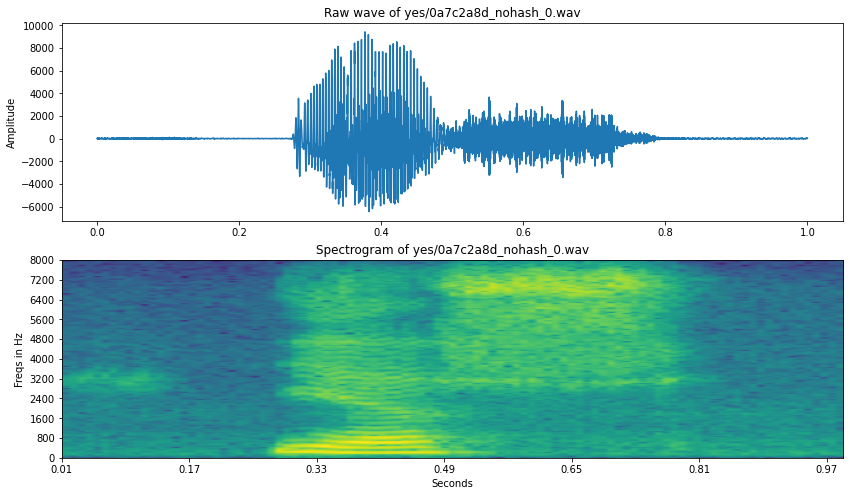

In [4]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower',
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [7]:
spectrogram.shape

(99, 161)

In [8]:
spectrogram[0][:10]

array([-6.779413  , -5.3643456 , -1.5105201 , -1.54615   , -1.3484015 ,
       -1.1671535 , -2.7261448 , -0.90997106, -1.9129319 , -3.6311882 ],
      dtype=float32)

In [9]:
max(spectrogram[0]), min(spectrogram[0])

(-0.90997106, -16.586145)

NeuralNet의 입력 features로 spectrogram을 사용하려면 features를 일반화(normalize)해야 한다.

In [5]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram-mean)/std
spectrogram.shape

(99, 161)

In [11]:
spectrogram[0][:10]

array([-0.10813524, -1.1658479 , -0.6403284 , -0.7812409 , -0.6259697 ,
       -0.5714372 , -0.8485003 , -0.23841354, -0.38025606, -0.8002787 ],
      dtype=float32)

In [12]:
max(spectrogram[0]), min(spectrogram[0])

(0.038348332, -2.1535375)

여기서 흥미로운 점은 각 frame이 160개의 features를 갖고 있다는 점이다. 주파수의 범위는 0~8000이므로 한 feature는 50Hz에 대응한다는 것을 알 수 있다. 그러나 [귀의 주파수 해상도는 1000 ~ 2000Hz의 옥타브 이내 3.6Hz이다.](https://en.wikipedia.org/wiki/Psychoacoustics) 이는 사람들이 위에서 spectrograms에 의해 표시된 것들보다 훨씬 더 정확하게(더 작고 자세하게) 들을 수 있다는 걸 의미한다.

### MFCC
[MFCC tutorial](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/)

librosa 패키지를 사용해서 **Mel power spectrogram과 MFCC**를 계산할 수 있다.

/Users/jaeyoungshin/opt/anaconda3/envs/python3.7/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning:

The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.

/Users/jaeyoungshin/opt/anaconda3/envs/python3.7/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning:

The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.



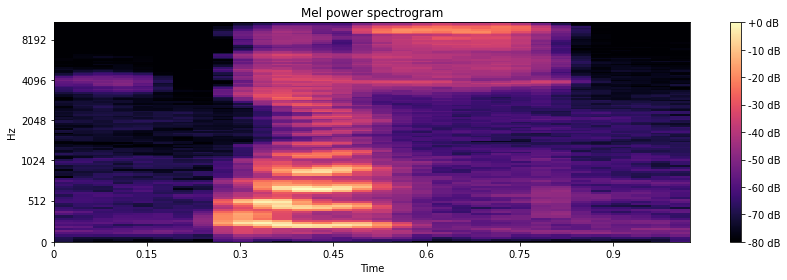

In [6]:
S = librosa.feature.melspectrogram(samples.astype(float), sr=sample_rate, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

고전에서나 최신의 시스템에서 MFCC 또는 비슷한 features는 spectrograms 대신에 시스템의 입력으로 취해진다.

그렇지만, end-to-end(often neural-network based) 시스템에서 가장 흔한 입력 features는 아마 raw spectrograms 또는 mel power spectrograms일 것이다. 예를 들면, MFCC는 features의 상관관계를 없앤다. 그러나 NN은 well-correlated featrues를 다룬다. 또한, mel filter를 이해한다면 사용법이 합리적이라고 생각할 것이다.

사람들마나 결정은 다를 수 있다.

### Spectrogram in 3D

In [7]:
data = [go.Surface(x=times, y=freqs, z=spectrogram.T)]
layout = go.Layout(
    title = 'Spectrogram of "yes" in 3D',
    scene = dict(
        yaxis = dict(title='Frequencies', range=[freqs.min(), freqs.max()]),
        xaxis = dict(title='Time', range=[times.min(), times.max()]),
        zaxis = dict(title='Log amplitude')
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

### Silence removal

In [25]:
ipd.Audio(samples, rate=sample_rate)

silence를 제거하는 **VAD(Voice Activity Detection)** 은 훈련 데이터의 크기를 줄여 훈련 속도를 크게 향상시킬 수 있다.

In [8]:
# 0.25 ~ 0.8125 * sample_rate(16000)
samples_cut = samples[4000:13000]
ipd.Audio(samples_cut, rate=sample_rate)

silence를 제거해도 'yes'가 명확히 들리는 것을 확인 가능하다.
모든 데이터를 수동으로 처리하기에는 불가능하므로 **webrtcvad** 패키지를 사용하여 VAD를 진행해보자.
여기서는 'y','e','s' 배열을 추측해보자.

In [34]:
fig.add_subplot?

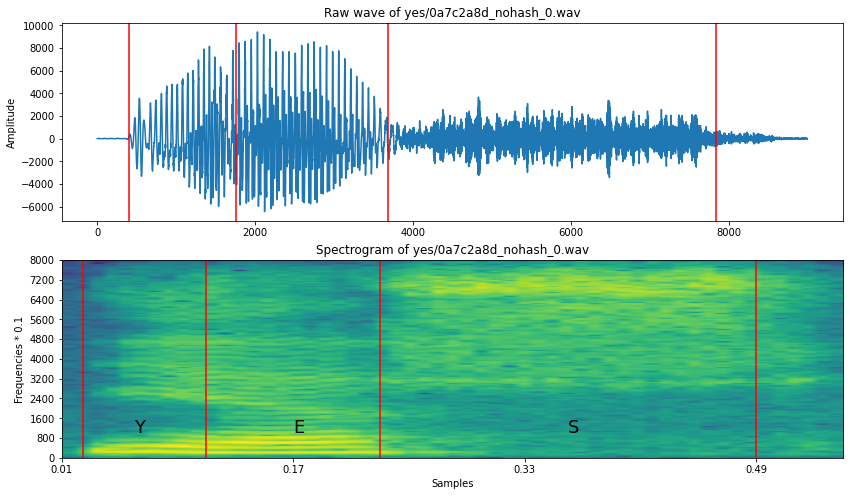

In [12]:
freqs, times, spectrogram_cut = log_specgram(samples_cut, sample_rate)

fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(samples_cut)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Frequencies * 0.1')
ax2.set_xlabel('Samples')
ax2.imshow(spectrogram_cut.T, aspect='auto', origin='lower',
          extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.text(0.06, 1000, 'Y', fontsize=18)
ax2.text(0.17, 1000, 'E', fontsize=18)
ax2.text(0.36, 1000, 'S', fontsize=18)

xcoords = [0.025, 0.11, 0.23, 0.49]
for xc in xcoords:
    ax1.axvline(x = xc*16000, c = 'r')
    ax2.axvline(x = xc, c = 'r')

어떻게 y,e,s 기준을 잡은거지?

### Resampling - dimensionality reduction

데이터의 차원을 줄이는 또 다른 방법은 recordings를 resample하는 것이다.

16k 주파수로 샘플링되었기 때문에 recording은 자연스럽게 안 들릴 것이다. 그렇지만 speech와 가장 많이 관계된 주파수는 더 낮은 대역대에 존재한다. → 8000Hz로 샘플링된 GSM(Global System for Mobile Communication) 신호인 전화 내용을 이해할 수 있는 이유이다.

요약하자면, 데이터셋을 8K로 재샘플링할 수 있고 중요하지 않은 정보를 약간 버림으로써 데이터 크기를 줄일 것이다.

이는 큰 위험이 있긴 하지만 빠르게 첫 실험을 해볼 수 있다.

In [14]:
def custom_fft(samples, sample_rate):
    T = 1.0 / sample_rate
    N = samples.shape[0]
    yf = fft(samples)
    # start, end, num
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    # real part만 취함
    vals = 2.0/N * np.abs(yf[0:N//2])
    return xf, vals

Let's read some recording, resample it, and listen. We can also compare FFT, Notice, that there is almost no information above 4000 Hz in original signal.

In [15]:
filename = 'happy/0b09edd3_nohash_0.wav'
new_sample_rate = 8000

sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
resampled = signal.resample(samples, int(new_sample_rate/sample_rate * samples.shape[0]))

In [43]:
ipd.Audio(samples, rate=sample_rate)

In [44]:
ipd.Audio(resampled, rate=new_sample_rate)

sample rate를 반으로 줄여 샘플링 했음에도 듣기에는 별 다른 차이가 없다.

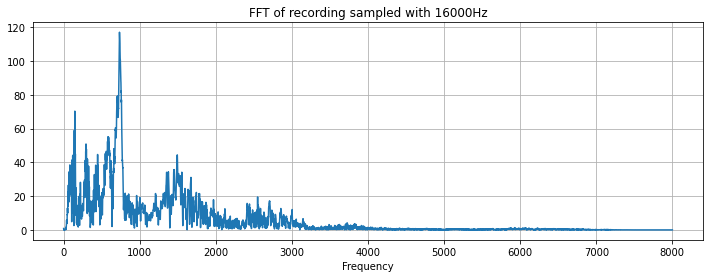

In [16]:
xf, vals = custom_fft(samples, sample_rate)
plt.figure(figsize=(12,4))
plt.title('FFT of recording sampled with ' + str(sample_rate) + 'Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

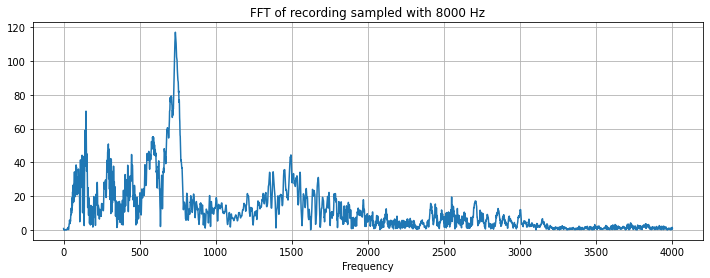

In [17]:
xf, vals = custom_fft(resampled, new_sample_rate)
plt.figure(figsize=(12,4))
plt.title('FFT of recording sampled with '+ str(new_sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

→ 이렇게 하면 데이터셋 크기가 반으로 줄어든 걸 확인할 수 있다.

### Features extraction steps

**Proposed the feature extraction algorithm**

1. Resampling
2. VAD
3. Maybe the padding with 0 to make signals be equal length
4. Log spectrogram (or *MFSS*(Mel Frequency Cepstral Coefficients), or *PLP*(Perceptual Linear Prediction))
5. Features normalization with *mean* and *std*
6. Stacking of a given number of frames to get temporal information

## Dataset investigation

### Number of records

In [18]:
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path,f))]
dirs.sort()
print('Number of labels: '+str(len(dirs)))

Number of labels: 31


In [21]:
number_of_recordings = []
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    number_of_recordings.append(len(waves))
data = [go.Histogram(x=dirs, y=number_of_recordings)]
trace = go.Bar(
    x = dirs,
    y = number_of_recordings,
    marker = dict(color=number_of_recordings, colorscale='Viridis', showscale=True))
layout = go.Layout(
    title = 'Number of recordings in given label',
    xaxis = dict(title='Words'),
    yaxis = dict(title='Number of recordings')
)
py.iplot(go.Figure(data=[trace], layout=layout))    

데이터셋은 background_noise(6개)를 제외하곤 대체적으로 균형있는 모습이다.

### Deeper into recordings

매우 중요한 사실이 있다. Recordings는 매우 다른 sources에서 생성됐다. 이것들 중 약간은 mobile GSM 채널에서 생성되었을 수 있다.

그럼에도 불구하고, **하나의 스피커에서 발생한 것이 훈련과 테스트셋 둘 다에 있지 않도록 나누는 것이 매우 중요하다.**

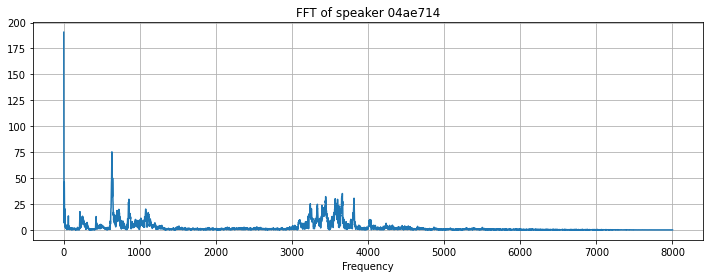

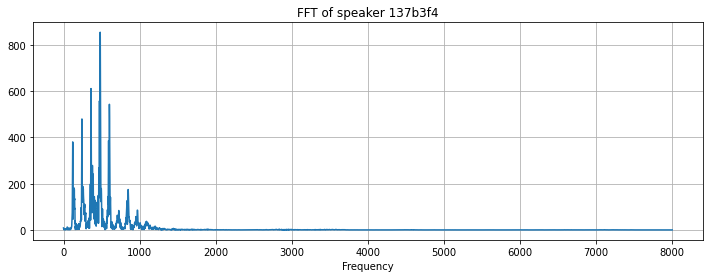

In [25]:
filenames = ['on/004ae714_nohash_0.wav', 'on/0137b3f4_nohash_0.wav']
for filename in filenames:
    sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
    xf, vals = custom_fft(samples, sample_rate)
    plt.figure(figsize=(12,4))
    plt.title('FFT of speaker ' + filename[4:11])
    plt.plot(xf, vals)
    plt.xlabel('Frequency')
    plt.grid()
    plt.show()

In [26]:
print('Speaker ' + filename[0][4:11])
sample_rate, samples = wavfile.read(str(train_audio_path)+filenames[0])
ipd.Audio(samples, rate=sample_rate)

Speaker 


In [27]:
print('Spaker ' + filenames[1][4:11])
sample_rate, samples = wavfile.read(str(train_audio_path) + filenames[1])
ipd.Audio(samples, rate=sample_rate)

Spaker 137b3f4


약간의 이상한 침묵(silence)를 가진 recordings도 있다.

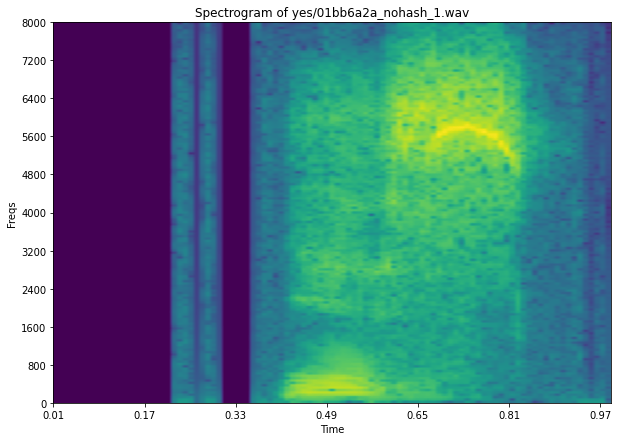

In [28]:
filename = 'yes/01bb6a2a_nohash_1.wav'
sample_rate, samples = wavfile.read(str(train_audio_path)+filename)
freqs, times, spectrogram = log_specgram(samples, sample_rate)

plt.figure(figsize=(10,7))
plt.title('Spectrogram of '+filename)
plt.ylabel('Freqs')
plt.xlabel('Time')
plt.imshow(spectrogram.T, aspect='auto', origin='lower',
          extent=[times.min(), times.max(), freqs.min(),freqs.max()])
plt.yticks(freqs[::16])
plt.xticks(times[::16])
plt.show()

In [29]:
ipd.Audio(samples, rate=sample_rate)